In [64]:
import zipfile
# from google.colab import files
import os
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import random
import matplotlib.pyplot as plt

In [65]:
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.layers import Input, Dropout, Add, Dense, Reshape, Activation
from tensorflow.keras.layers import BatchNormalization, Flatten, Conv1D, MaxPooling1D
from tensorflow.keras.optimizers import Adam

In [66]:
# Upload signals, labels, snrs

SNR = -8

label = np.loadtxt('./dataset/label.txt')
labels = label.reshape(16000, 4)
signal = np.loadtxt('./dataset/signal.txt')
signals = signal.reshape(16000, 1024, 2)
index = [i for i in range(len(signals))]
random.shuffle(index)
signals = signals[index]
labels = labels[index]
print(labels)

[[0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 ...
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]]


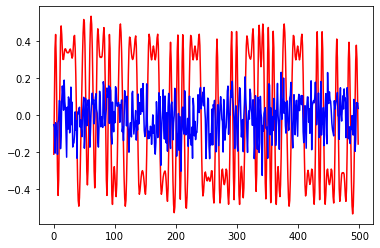

In [67]:
 # add noise
def awgn(x, snr, seed=7):
    '''
    加入高斯白噪声 Additive White Gaussian Noise
    :param x: 原始信号
    :param snr: 信噪比
    :return: 加入噪声后的信号
    '''
    sample_nums = x.shape[0]
    sample_noise = []
    for sample_num in range(sample_nums):
        for channel in range(2):
            sample = x[sample_num,:,channel]
            np.random.seed(seed)  # 设置随机种子
            snr = 10 ** (snr / 10.0)
            xpower = np.sum(sample ** 2) / len(sample)
            npower = xpower / snr
            noise = np.random.randn(len(sample)) * np.sqrt(npower)
            sample_noise.append(sample + noise)
    return np.array(sample_noise).reshape(x.shape)
signals_noise = awgn(signals,SNR)
plt.plot(signals[1,1:500,1],'r')
plt.plot(signals_noise[1,1:500,1],'b')

In [68]:
print(signals.shape)
print(labels.shape)

(16000, 1024, 2)
(16000, 4)


In [69]:
# import matplotlib.pyplot as plt
# plt.plot(signals[1,1:500,1])
# print(labels[1,:])
# plt.plot(signals[2,1:500,1])
# print(labels[2,:])


In [70]:
# plt.plot(signals[3,1:500,1])
# print(labels[3,:])
# plt.plot(signals[4,1:500,1])
# print(labels[4,:])

In [71]:
# plt.plot(x_test[5,1:500,1])
# print(labels[5,:])
# plt.plot(signals[6,1:500,1])
# print(labels[6,:])

In [72]:
# Split arrays for two 3 parts (we take only third part of dataset of labeled signals because of the memory)
part = 1
signals_noise = signals_noise[::part, :, :]
labels = labels[::part]
print(signals_noise.shape)
print(labels.shape)

(16000, 1024, 2)
(16000, 4)


In [73]:
# Mask array of signals and labels (snrs > 8)
#signals = signals[msk]
#labels = labels[msk]
# print(len(labels))
# print(len(signals_noise))


In [74]:
# Train|test = 80|20


x_train, x_test, y_train, y_test = train_test_split(signals_noise, labels, train_size=0.8)
# print(f"Количество строк в y_train по классам: {np.bincount(y_train)}")
# print(f"Количество строк в y_test по классам: {np.bincount(y_test)}")
print(x_test.shape)
print(y_test.shape)

# Train|validation|test = 64|16|20
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=0.8)

# print(f"Количество строк в y_train по классам: {np.bincount(y_test)}")
# print(f"Количество строк в y_test по классам: {np.bincount(y_val)}")
print(x_train.shape)
print(y_train.shape)

(3200, 1024, 2)
(3200, 4)
(10240, 1024, 2)
(10240, 4)


In [75]:
# Create residual and convolution blok
class Residual_block:
    kernel_size = 3
    strides = 1
    padding = 'same'
    data_format = "channels_last"

    def __init__(self, x, x_shortcut, filters):
        self.x = x
        self.filters = filters
        self.x_shortcut = x_shortcut

    def unit(self):
        x = Conv1D(self.filters, self.kernel_size, self.strides, self.padding, self.data_format)(self.x)
        x = Activation('relu')(x)
        x = Conv1D(self.filters, self.kernel_size, self.strides, self.padding, self.data_format)(x)
        x = Activation('linear')(x)
        # add skip connection
        if x.shape[1:] == self.x_shortcut.shape[1:]:
            x = Add()([x, self.x_shortcut])
        else:
            raise Exception('Skip Connection Failure!')
        return x


class Convolution_block:
    kernel_size = 1
    strides = 1
    padding = 'same'
    data_format = "channels_last"

    def __init__(self, x, filters):
        self.x = x
        self.filters = filters

    def unit(self):
        x = Conv1D(self.filters, self.kernel_size, self.strides, self.padding, self.data_format)(self.x)
        x = Activation('linear')(x)
        return x

In [76]:
# Create residual stack
def residual_stack(x, filters):
    x = Convolution_block(x, filters)
    print('x')
    #     print(x.shape)
    print(x)
    x = x.unit()
    print('xunit')
    #     print(x.shape)
    print(x)

    x_shortcut = x
    x = Residual_block(x, x_shortcut, filters)
    x = x.unit()
    x_shortcut = x
    x = Residual_block(x, x_shortcut, filters)
    x = x.unit()

    # max pooling layer
    x = MaxPooling1D(pool_size=2, strides=None, padding='valid', data_format='channels_last')(x)
    #     print('Residual stack created')
    return x

In [77]:
# define resnet model
def ResNet(input_shape, classes):
    # create input tensor
    x_input = Input(input_shape)
    x = x_input
    # residual stack
    num_filters = 20
    x = residual_stack(x, num_filters)
    x = residual_stack(x, num_filters)
    x = residual_stack(x, num_filters)
    x = residual_stack(x, num_filters)
    x = residual_stack(x, num_filters)

    # output layer
    x = Flatten()(x)
    x = Dense(128, activation="selu", kernel_initializer="he_normal")(x)
    x = Dropout(.5)(x)
    x = Dense(128, activation="selu", kernel_initializer="he_normal")(x)
    x = Dropout(.5)(x)
    x = Dense(classes, activation='softmax', kernel_initializer=glorot_uniform(seed=0))(x)

    # Create model
    model = Model(inputs=x_input, outputs=x)
    #     print('Model ResNet created')
    return model

In [78]:
# option to save model weights and model history
save_model = False
save_history = False

# create directory for model weights
if save_model is True:
    weights_path = input("Name model weights directory: ")
    weights_path = "data/weights/" + weights_path

    try:
        os.mkdir(weights_path)
    except OSError:
        print("Creation of the directory %s failed" % weights_path)
    else:
        print("Successfully created the directory %s " % weights_path)
    print('\n')

# create directory for model history
if save_history is True:
    history_path = input("Name model history directory: ")
    history_path = "data/model_history/" + history_path

    try:
        os.mkdir(history_path)
    except OSError:
        print("Creation of the directory %s failed" % history_path)
    else:
        print("Successfully created the directory %s " % history_path)
    print('\n')

In [79]:
# initialize optimizer 
adm = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

# set number of epochs
num_epochs = int(input('Enter number of epochs: '))

# set batch size
batch = 1

# configure weights save

if save_model is True:
    filepath = weights_path + "/{epoch}.hdf5"
    checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=False,
                                                 mode="auto")
    callbacks_list = [checkpoint]
else:
    callbacks_list = []

In [80]:
# initialize and train model.shape
print(x_train.shape)
print(y_train.shape)
model = ResNet((1024, 2), 4)
model.compile(optimizer=adm, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()
history = model.fit(x_train, y_train, epochs=num_epochs, batch_size=batch, callbacks=callbacks_list,
                    validation_data=(x_val, y_val))

(10240, 1024, 2)
(10240, 4)
x
xunit
Tensor("activation_50/activation_50/Identity:0", shape=(None, 1024, 20), dtype=float32)
x
xunit
Tensor("activation_55/activation_55/Identity:0", shape=(None, 512, 20), dtype=float32)
x
xunit
Tensor("activation_60/activation_60/Identity:0", shape=(None, 256, 20), dtype=float32)
x
xunit
Tensor("activation_65/activation_65/Identity:0", shape=(None, 128, 20), dtype=float32)
x
xunit
Tensor("activation_70/activation_70/Identity:0", shape=(None, 64, 20), dtype=float32)
Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 1024, 2)]    0                                            
__________________________________________________________________________________________________
conv1d_50 (Conv1D)              (None, 1024, 20)     60          input_3[0][0] 

KeyboardInterrupt: 

In [ ]:
import numpy as np

test1 = np.loadtxt(r'.\dataset\EightPSK5.txt')
test2 = np.loadtxt(r'.\dataset\OQPSK5.txt')
test3 = np.loadtxt(r'.\dataset\QPSK5.txt')
test4 = np.loadtxt(r'.\dataset\UQPSK5.txt')
test1 = test1.reshape(4000, 1024, 2)
test1_noise = awgn(test1,SNR)
test2 = test2.reshape(4000, 1024, 2)
test2_noise = awgn(test2,SNR)
test3 = test3.reshape(4000, 1024, 2)
test3_noise = awgn(test3,SNR)
test4 = test4.reshape(4000, 1024, 2)
test4_noise = awgn(test4,SNR)
print('EightPSK:.')
test1_predict = model.predict(test1_noise)
test2_predict = model.predict(test2_noise)
print(test1_predict.shape)
print(test1_predict)
print('OQPSK:')
print(test2_predict.shape)
print(test2_predict)
print('QPSK:')
test3_predict = model.predict(test3_noise)
test4_predict = model.predict(test4_noise)
print(test3_predict.shape)
print(test3_predict)
print('UQPSK:')
print(test4_predict.shape)
print(test4_predict)
print(',,,,,,,,,')
test5 = np.loadtxt(r'.\dataset\QPSK4.txt')
test5 = test5.reshape(4000, 1024, 2)
test5_noise = awgn(test5,SNR)
print('QPSK4:')
test5_predict = model.predict(test5_noise)
print(test5_predict)



In [ ]:

with open(r'./dataset/classes.txt') as file:
    classes = file.read()


def str_to_list(line):
    line = line.replace('\n', '')
    line = line.replace('classes = ', '')
    line = eval(line)
    return line


classes = str_to_list(classes)
print(classes)

In [ ]:
print(type(x_test))
noise = np.random.randn(3200, 1024, 2)
x_test1 = x_test + noise
plt.plot(x_test1[1, 1:100, 1])
plt.plot(x_test[1, 1:100, 1])

In [ ]:

loss, acc = model.evaluate(x_test, y_test, batch_size=1)
print('EVALUATING MODEL ON TEST DATA:')
print('Test Accuracy: ', str(round(acc * 100, 2)), '%')
print('\n')

In [ ]:
train_accuracy = history.history['accuracy']
train_loss = history.history['loss']
val_accuracy = history.history['val_accuracy']
val_loss = history.history['val_loss']

if save_history is True:
    # save model history: loss and accuracy
    np.save(history_path + '/train_acc.npy', train_accuracy)
    np.save(history_path + '/train_loss.npy', train_loss)
    np.save(history_path + '/val_acc.npy', val_accuracy)
    np.save(history_path + '/val_loss.npy', val_loss)
    print("Model History Saved!")
    print('\n')

In [ ]:
import itertools

predictions = model.predict(x_test)
classes_y = np.argmax(predictions, axis=1)
# conf_matrix = confusion_matrix(y_true=np.argmax(y_test,axis=1), y_pred=classes_y)

In [ ]:
# nr_rows = conf_matrix.shape[0]
# nr_cols = conf_matrix.shape[1]
#
# plt.figure(figsize=(18,18), dpi= 200)
# im = plt.imshow(conf_matrix, cmap=plt.cm.Greens)
# ax = plt.gca()
# plt.title('Confusion Matrix', fontsize=16)
# plt.ylabel('Actual Labels', fontsize=12)
# plt.xlabel('Predicted Labels', fontsize=12)
# tick_marks = np.arange(len(classes))
# plt.yticks(tick_marks, classes)
# # plt.xticks(tick_marks, classes)
#
# for i, j in itertools.product(range(nr_rows), range(nr_cols)):
#     plt.text(j, i, conf_matrix[i, j], horizontalalignment='center',
#             color='white' if conf_matrix[i, j] > conf_matrix.max()/2 else 'black')
#

# Divide existing axes and create new axes
# at bottom side of image
#divider = make_axes_locatable(ax)
#cax = divider.append_axes("right", size="5%", pad=0.05)
#plt.colorbar(im, cax=cax) 

In [ ]:
history = [[train_accuracy, val_accuracy], [train_loss, val_loss]]
title = ['Model accuracy', 'Model loss']
ylabel = ['accuracy', 'loss']
fig = plt.figure(figsize=(20, 7), dpi=80)
for i, id in enumerate(title):
    plt.subplot(1, 2, i + 1)

    plt.plot(history[i][0], label='train')
    plt.plot(history[i][1], label='val')
    plt.title(id)
    plt.xlabel('epoch')
    plt.ylabel(ylabel[i])
    plt.legend(loc='upper right')
plt.tight_layout(pad=1.7)

In [ ]:
idx = [0, 1, 2, 3]
fig = plt.figure(figsize=(20, 5), dpi=80)
for i, id in enumerate(idx):
    plt.subplot(2, 2, i + 1)
    plt.plot(signals[id][:, 0], color='green', label='I component')
    plt.plot(signals[id][:, 1], color='salmon', label='Q component')
    plt.title(classes[id])
    plt.xlabel('Points')
    plt.ylabel('Amplitude')
    plt.legend(loc='upper right')
plt.tight_layout(pad=1.7)